<a href="https://colab.research.google.com/github/yoakiyama/MSA_Pairformer/blob/main/MSA_Pairformer_with_MMseqs2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Setup (installing packages)
# @markdown Please execute this cell to install necessary packages by pressing the _Play_ button
# @markdown on the left.

##### Install packages #####
import os
import subprocess
import importlib
import sys
from sys import version_info
# python_version = f"{version_info.major}.{version_info.minor}"
# if not os.path.isdir("colabfold_utils.py"):
#   os.system("wget https://raw.githubusercontent.com/sokrypton/ColabFold/main/colabfold/colabfold.py -O colabfold_utils.py")

#   # install hhsuite
#   print("installing HHsuite")
#   os.makedirs("hhsuite", exist_ok=True)
#   os.system(f"curl -fsSL https://github.com/soedinglab/hh-suite/releases/download/v3.3.0/hhsuite-3.3.0-SSE2-Linux.tar.gz | tar xz -C hhsuite/")

# if "hhsuite" not in os.environ['PATH']:
#   os.environ['PATH'] += ":hhsuite/bin:hhsuite/scripts"

# Install MSA Pairformer
GIT_REPO = 'https://github.com/yoakiyama/MSA_Pairformer'
TMP_DIR = "tmp"
os.makedirs(TMP_DIR, exist_ok=True)
if not os.path.isdir("MSA_Pairformer"):
  result = subprocess.run(
      f"git clone {GIT_REPO}.git",
      shell = True,
      capture_output = True,
      text = True
  )
  !pip install -e MSA_Pairformer/ --no-deps
  os.system(f"pip install biopython einx jaxtyping")
  importlib.invalidate_caches()
  # Add the package to Python path
  package_path = os.path.abspath("MSA_Pairformer")
  if package_path not in sys.path:
      sys.path.insert(0, package_path)


"""
Complete MSA Pipeline for Google Colab
Single file containing all functionality for MSA generation
"""

import re
import urllib.request
import numpy as np
from typing import List, Union, Optional, Tuple
from string import ascii_uppercase


# ============================================================================
# PART 1: Dependency Management
# ============================================================================

class MSADependencies:
    """Setup and manage dependencies for MSA generation (HHsuite and ColabFold)."""

    def __init__(self, install_dir: str = "."):
        self.install_dir = install_dir
        self.hhsuite_path = os.path.join(install_dir, "hhsuite")
        self.colabfold_utils_path = os.path.join(install_dir, "colabfold_utils.py")

    def setup_all(self, force_reinstall: bool = False):
        """Setup all dependencies."""
        self.install_hhsuite(force_reinstall)
        self.download_colabfold_utils(force_reinstall)
        self.setup_environment()

    def install_hhsuite(self, force_reinstall: bool = False):
        """Install HHsuite for sequence filtering."""
        if os.path.isdir(self.hhsuite_path) and not force_reinstall:
            print("HHsuite already installed")
            return

        print("Installing HHsuite...")
        os.makedirs(self.hhsuite_path, exist_ok=True)

        hhsuite_url = "https://github.com/soedinglab/hh-suite/releases/download/v3.3.0/hhsuite-3.3.0-SSE2-Linux.tar.gz"
        cmd = f"curl -fsSL {hhsuite_url} | tar xz -C {self.hhsuite_path}/"

        result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
        if result.returncode != 0:
            raise RuntimeError(f"Failed to install HHsuite: {result.stderr}")

        print("HHsuite installed successfully")

    def download_colabfold_utils(self, force_reinstall: bool = False):
        """Download ColabFold utilities for MMseqs2 webserver access."""
        if os.path.isfile(self.colabfold_utils_path) and not force_reinstall:
            print("ColabFold utils already downloaded")
            return

        print("Downloading ColabFold utilities...")
        colabfold_url = "https://raw.githubusercontent.com/sokrypton/ColabFold/main/colabfold/colabfold.py"

        try:
            urllib.request.urlretrieve(colabfold_url, self.colabfold_utils_path)
            print("ColabFold utilities downloaded successfully")
        except Exception as e:
            raise RuntimeError(f"Failed to download ColabFold utilities: {e}")

    def setup_environment(self):
        """Add HHsuite to PATH if not already present."""
        hhsuite_bin = os.path.join(self.hhsuite_path, "bin")
        hhsuite_scripts = os.path.join(self.hhsuite_path, "scripts")

        if hhsuite_bin not in os.environ['PATH']:
            os.environ['PATH'] += f":{hhsuite_bin}:{hhsuite_scripts}"
            print("Added HHsuite to PATH")

    def get_mmseqs2_runner(self, user_agent: str = "colabdesign/gamma"):
        """Get MMseqs2 runner function with proper user agent."""
        import sys
        if self.install_dir not in sys.path:
            sys.path.insert(0, self.install_dir)

        from colabfold_utils import run_mmseqs2

        def run_mmseqs2_wrapper(*args, **kwargs):
            kwargs['user_agent'] = user_agent
            return run_mmseqs2(*args, **kwargs)

        return run_mmseqs2_wrapper

    def get_hhfilter_runner(self):
        """Get HHfilter runner function."""
        def run_hhfilter(input_file: str, output_file: str, id: int = 90, qid: int = 10):
            cmd = f"hhfilter -id {id} -qid {qid} -i {input_file} -o {output_file}"
            result = subprocess.run(cmd, shell=True, capture_output=True, text=True)

            if result.returncode != 0:
                raise RuntimeError(f"HHfilter failed: {result.stderr}")

        return run_hhfilter


# ============================================================================
# PART 2: MSA Generator
# ============================================================================

class MSAGenerator:
    """Generate Multiple Sequence Alignments using MMseqs2 and HHfilter."""

    def __init__(self, mmseqs2_fn, hhfilter_fn):
        self.mmseqs2_fn = mmseqs2_fn
        self.hhfilter_fn = hhfilter_fn

    def generate(
        self,
        sequences: Union[str, List[str]],
        jobname: str,
        coverage: float = 50,
        seq_identity: float = 90,
        query_identity: float = 10,
        max_sequences: int = 4096,
        output_a3m: Optional[str] = None,
        verbose: bool = True,
        pair_distance: Optional[int] = None,
        neighbor_stitching: Optional[bool] = True
    ) -> str:
        """
        Generate MSA and save to a3m file.

        Args:
            sequences: Single sequence or list of sequences for multi-chain proteins
            jobname: Job name for output directory
            coverage: Minimum sequence coverage (0-1 or 0-100)
            seq_identity: Sequence identity threshold for filtering (0-1 or 0-100)
            query_identity: Query identity threshold for filtering (0-1 or 0-100)
            max_sequences: Maximum number of sequences in final MSA
            output_a3m: Output file path (default: {jobname}/msa.a3m)
            verbose: Print progress messages
            pair_distance: For multi-chain proteins, maximum UniProt ID distance for pairing

        Returns:
            Path to output a3m file
        """
        # Normalize inputs - handle both 0-1 and 0-100 formats
        coverage = coverage / 100 if coverage > 1 else coverage
        seq_identity = int(seq_identity * 100) if seq_identity <= 1 else int(seq_identity)
        query_identity = int(query_identity * 100) if query_identity <= 1 else int(query_identity)

        sequences = [sequences] if isinstance(sequences, str) else sequences
        sequence_lengths = [len(seq) for seq in sequences]

        # Setup paths
        msa_path = os.path.join(jobname, "msa")
        os.makedirs(msa_path, exist_ok=True)
        output_a3m = output_a3m or f"{jobname}/msa.a3m"

        # Get MSA from MMseqs2
        if verbose:
            print(f"Generating MSA for {len(sequences)} sequence(s)...")
            print(f"Parameters: coverage={coverage:.2f}, seq_identity={seq_identity}%, query_identity={query_identity}%")

        msa_raw, msa_names = self._get_msa(sequences, msa_path, len(sequences) > 1)

        # Store names for later use
        self._msa_names = msa_names

        # Apply pairing filter for multi-chain proteins
        if len(sequences) > 1 and (pair_distance is not None) and (neighbor_stitching):
            if verbose:
                print(f"Filtering pairs by UniProt ID distance (max={pair_distance})...")
            msa_raw, msa_names = self._filter_by_uniprot_distance(
                msa_raw, msa_names, pair_distance, verbose
            )
            self._msa_names = msa_names

        # Filter sequences by coverage and identity
        if verbose:
            print("Filtering sequences...")

        filtered_indices = self._filter_sequences(
            msa_raw, sequences, sequence_lengths,
            coverage, seq_identity, query_identity,
            msa_path, verbose
        )

        # Select final sequences
        if verbose:
            print("Selecting final sequences...")

        final_indices = self._select_balanced(filtered_indices, len(sequences), max_sequences)

        # Write output
        self._write_a3m(output_a3m, sequences, msa_raw, final_indices)

        if verbose:
            print(f"Saved {len(final_indices) + 1} sequences to {output_a3m}")

        return output_a3m

    def _get_msa(self, sequences, output_path, use_pairing):
        """Get MSA from MMseqs2 webserver."""
        msa_raw = []
        msa_names = []

        if use_pairing:
            # Multi-chain: use paired MSA
            results = self.mmseqs2_fn(sequences, f"{output_path}/", use_pairing=True)

            for a3m_content in results:
                seq_index = -1
                for line in a3m_content.split("\n"):
                    if line.strip():
                        if line.startswith(">"):
                            seq_index += 1
                            if len(msa_raw) < (seq_index + 1):
                                msa_raw.append([])
                                msa_names.append([])
                            # Extract sequence name
                            name = line.split()[0][1:]
                            msa_names[seq_index].append(name)
                        else:
                            msa_raw[seq_index].append(line)
        else:
            # Single sequence: unpaired MSA
            results = self.mmseqs2_fn(sequences, f"{output_path}/", use_pairing=False)

            for line in results[0].split("\n"):
                if line.strip():
                    if line.startswith(">"):
                        name = line.split()[0][1:]
                        msa_names.append([name])
                    elif not line.startswith(">"):
                        msa_raw.append([line.rstrip()])

        return msa_raw, msa_names

    def _filter_by_uniprot_distance(self, msa_raw, msa_names, max_distance, verbose):
        """Filter paired sequences by UniProt ID distance."""
        filtered_raw = []
        filtered_names = []

        num_chains = len(msa_raw[0]) if msa_raw else 0
        if num_chains < 2:
            return msa_raw, msa_names

        original_count = len(msa_raw)
        kept_count = 0

        for idx in range(len(msa_raw)):
            # Extract UniProt IDs from all chains
            uniprot_ids = []
            for chain_idx in range(num_chains):
                name = msa_names[idx][chain_idx]
                uniprot_id = self._extract_uniprot_id(name)
                if uniprot_id is None:
                    break
                uniprot_ids.append(uniprot_id)

            # Skip if any chain lacks valid UniProt ID
            if len(uniprot_ids) != num_chains:
                continue

            # Convert UniProt IDs to numbers and check distances
            numbers = self._uniprot_to_number(uniprot_ids)
            distances = []
            valid = True

            # Calculate all pairwise distances
            for i in range(len(numbers)):
                for j in range(i + 1, len(numbers)):
                    distance = abs(numbers[i] - numbers[j])
                    distances.append(distance)
                    if distance > max_distance:
                        valid = False
                        break
                if not valid:
                    break

            if valid:
                kept_count += 1
                filtered_raw.append(msa_raw[idx])

                # Create header with UniProt IDs and distances
                if num_chains == 2:
                    header = f"{uniprot_ids[0]}_{uniprot_ids[1]}_{distances[0]}"
                else:
                    header = "_".join(uniprot_ids) + "_" + "_".join(map(str, distances))

                # Store header in first position, empty strings for other chains
                filtered_names.append([header] + [""] * (num_chains - 1))

                # Show examples for debugging
                if verbose and kept_count <= 3:
                    print(f"  Example {kept_count}: {header}")

        if verbose:
            print(f"  Kept {kept_count}/{original_count} paired sequences")
            if num_chains > 2:
                print(f"  Note: All {len(distances)} pairwise distances must be ≤ {max_distance}")

        return filtered_raw, filtered_names

    def _extract_uniprot_id(self, name):
        """Extract UniProt ID from sequence name."""
        if name.startswith("UniRef"):
            parts = name.split("_")
            if len(parts) >= 2 and "UPI" not in parts[1]:
                return parts[1]
        elif "_" in name:
            parts = name.split("_")
            if len(parts) >= 2 and "UPI" not in parts[1]:
                return parts[1]
        return None

    def _uniprot_to_number(self, uniprot_ids):
        """Convert UniProt IDs to numbers for distance calculation."""
        # Initialize encoding tables
        pa = {a: 0 for a in ascii_uppercase}
        for a in ["O", "P", "Q"]:
            pa[a] = 1

        ma = [[{} for k in range(6)], [{} for k in range(6)]]

        # Fill encoding tables
        for n, t in enumerate(range(10)):
            for i in [0, 1]:
                for j in [0, 4]:
                    ma[i][j][str(t)] = n

        for n, t in enumerate(list(ascii_uppercase) + list(range(10))):
            for i in [0, 1]:
                for j in [1, 2]:
                    ma[i][j][str(t)] = n
            ma[1][3][str(t)] = n

        for n, t in enumerate(ascii_uppercase):
            ma[0][3][str(t)] = n
            for i in [0, 1]:
                ma[i][5][str(t)] = n

        # Convert IDs to numbers
        numbers = []
        for uni in uniprot_ids:
            if not uni or not uni[0].isalpha():
                numbers.append(0)
                continue

            p = pa.get(uni[0], 0)
            tot, num = 1, 0

            if len(uni) == 10:
                for n, u in enumerate(reversed(uni[-4:])):
                    if str(u) in ma[p][n]:
                        num += ma[p][n][str(u)] * tot
                        tot *= len(ma[p][n].keys())

            for n, u in enumerate(reversed(uni[:6])):
                if n < len(ma[p]) and str(u) in ma[p][n]:
                    num += ma[p][n][str(u)] * tot
                    tot *= len(ma[p][n].keys())

            numbers.append(num)

        return numbers

    def _filter_sequences(self, msa_raw, sequences, sequence_lengths,
                         coverage, seq_identity, query_identity, msa_path, verbose):
        """Filter sequences by coverage and identity."""
        # Parse sequences (remove lowercase insertions)
        msa_parsed = []
        for raw_seq in msa_raw:
            combined_seq = "".join(raw_seq)
            parsed_seq = [char for char in combined_seq if not char.islower()]
            msa_parsed.append(parsed_seq)

        # For multi-chain: only keep sequences covering all chains
        num_chains = len(sequences)
        if num_chains > 1:
            valid_indices = []
            for idx, seq in enumerate(msa_parsed):
                if self._covers_all_chains(seq, sequence_lengths, coverage):
                    valid_indices.append(idx)

            if verbose:
                print(f"  Found {len(valid_indices)} sequences covering all {num_chains} chains")

            if not valid_indices:
                return {}
        else:
            # For single chain: keep all sequences meeting coverage threshold
            valid_indices = []
            for idx, seq in enumerate(msa_parsed):
                gap_count = seq.count("-")
                seq_coverage = 1 - (gap_count / len(seq))
                if seq_coverage >= coverage:
                    valid_indices.append(idx)

            if verbose:
                print(f"  Found {len(valid_indices)} sequences with ≥{coverage:.0%} coverage")

        # Write sequences for HHfilter
        group_file = f"{msa_path}/sequences.a3m"
        with open(group_file, "w") as f:
            # Query sequence
            f.write(f">query\n{''.join(sequences)}\n")
            # MSA sequences
            for idx in valid_indices:
                f.write(f">{idx}\n{''.join(msa_raw[idx])}\n")

        # Apply HHfilter
        filtered_file = f"{msa_path}/sequences.filtered.a3m"
        self.hhfilter_fn(group_file, filtered_file, id=seq_identity, qid=query_identity)

        # Read filtered indices
        filtered_indices = []
        with open(filtered_file, "r") as f:
            for line in f:
                if line.startswith(">") and not line.startswith(">query"):
                    filtered_indices.append(int(line[1:].strip()))

        if verbose:
            print(f"  After HHfilter: {len(filtered_indices)} sequences")

        # Return as dict for compatibility with _select_balanced
        return {"all": filtered_indices} if filtered_indices else {}

    def _covers_all_chains(self, seq, sequence_lengths, min_coverage):
        """Check if sequence covers all chains with minimum coverage."""
        pos = 0
        for length in sequence_lengths:
            chain_seq = seq[pos:pos + length]
            gap_count = chain_seq.count("-")
            coverage = 1 - (gap_count / length)

            if coverage < min_coverage:
                return False
            pos += length

        return True

    def _select_balanced(self, filtered_indices, num_chains, max_sequences):
        """Select sequences up to max_sequences limit."""
        # Simply take all filtered sequences up to the limit
        all_indices = []
        for indices in filtered_indices.values():
            all_indices.extend(indices)

        # Limit to max_sequences (excluding query)
        return all_indices[:max_sequences - 1]

    def _write_a3m(self, filepath, sequences, msa_raw, indices):
        """Write final MSA to a3m file."""
        with open(filepath, "w") as f:
            f.write(f">query\n{''.join(sequences)}\n")
            for idx in indices:
                # Use custom header if available (from UniProt filtering)
                if hasattr(self, '_msa_names') and idx < len(self._msa_names):
                    names = self._msa_names[idx]
                    header = next((name for name in names if name), str(idx))
                else:
                    header = str(idx)
                f.write(f">{header}\n{''.join(msa_raw[idx])}\n")


# ============================================================================
# PART 3: Helper Functions
# ============================================================================

def prepare_sequences(sequence: str, remove_duplicates: bool = True) -> Tuple[List[str], List[int]]:
    """
    Clean and prepare sequences from input string.

    Args:
        sequence: Raw sequence string, chains separated by ':'
        remove_duplicates: If True, removes duplicate sequences while preserving order

    Returns:
        Tuple of (cleaned sequences, chain break indices)
    """
    # Clean sequence
    sequence = sequence.upper()
    sequence = re.sub("[^A-Z:/()]", "", sequence)
    sequence = re.sub("\(", ":(", sequence)
    sequence = re.sub("\)", "):", sequence)
    sequence = re.sub(":+", ":", sequence)
    sequence = re.sub("/+", "/", sequence)
    sequence = re.sub("^[:/]+", "", sequence)
    sequence = re.sub("[:/]+$", "", sequence)

    # Split into individual sequences
    sequences = sequence.split(":")
    sequences = [seq for seq in sequences if seq]

    # Remove duplicates while preserving order
    if remove_duplicates and len(sequences) > 1:
        seen = set()
        unique_sequences = []

        for seq in sequences:
            if seq not in seen:
                seen.add(seq)
                unique_sequences.append(seq)

        if len(unique_sequences) < len(sequences):
            print(f"Note: Removed {len(sequences) - len(unique_sequences)} duplicate sequence(s)")

        sequences = unique_sequences

    # Calculate chain break indices for the final sequences
    chain_breaks = []
    position = 0
    for i, seq in enumerate(sequences[:-1]):  # All except last sequence
        position += len(seq)
        chain_breaks.append(position)

    return sequences, chain_breaks


def get_unique_jobname(base_jobname: str) -> str:
    """Get a unique jobname by incrementing if directory already exists."""
    if not os.path.exists(base_jobname):
        return base_jobname

    counter = 1
    while os.path.exists(f"{base_jobname}_{counter}"):
        counter += 1

    return f"{base_jobname}_{counter}"


def setup_msa_environment(install_dir: str = ".") -> Tuple:
    """Setup MSA environment and get runner functions."""
    deps = MSADependencies(install_dir)
    deps.setup_all()

    mmseqs2_fn = deps.get_mmseqs2_runner()
    hhfilter_fn = deps.get_hhfilter_runner()

    return mmseqs2_fn, hhfilter_fn

mmseqs2_fn, hhfilter_fn = setup_msa_environment()
msa_gen = MSAGenerator(
    mmseqs2_fn=mmseqs2_fn,
    hhfilter_fn=hhfilter_fn
)

HHsuite already installed
ColabFold utils already downloaded
Added HHsuite to PATH


In [ ]:
#@title Load packages and utility functions
##### Load packages and define utility functions #####
import re, tempfile
import matplotlib.pyplot as plt
import string

import tqdm.notebook
from google.colab import files
from IPython.utils import io

import torch
import numpy as np
import matplotlib.pyplot as plt

from MSA_Pairformer.model import MSAPairformer
from MSA_Pairformer.dataset import MSA, aa2tok_d, prepare_msa_masks

from colabfold_utils import run_mmseqs2

def run_mmseqs2_wrapper(*args, **kwargs):
  kwargs['user_agent'] = "colabdesign/gamma"
  return run_mmseqs2(*args, **kwargs)

def parse_hhalign_output(filename):
  with open(filename, "r") as f:
    lines = f.readlines()
  start_indices, sequences = [None,None], ["",""]
  for line in lines:
    parts = line.split()
    if line.startswith('Q '):
      if start_indices[0] is None:
        start_indices[0] = int(parts[2]) - 1
      sequences[0] += parts[3]
    if line.startswith('T '):
      if start_indices[1] is None:
        start_indices[1] = int(parts[2]) - 1
      sequences[1] += parts[3]
  return sequences, start_indices

def run_hhalign(query_sequence, target_sequence, query_a3m=None, target_a3m=None):
  with tempfile.NamedTemporaryFile() as tmp_query, \
  tempfile.NamedTemporaryFile() as tmp_target, \
  tempfile.NamedTemporaryFile() as tmp_alignment:
    if query_a3m is None:
      tmp_query.write(f">Q\n{query_sequence}\n".encode())
      tmp_query.flush()
      query_a3m = tmp_query.name
    if target_a3m is None:
      tmp_target.write(f">T\n{target_sequence}\n".encode())
      tmp_target.flush()
      target_a3m = tmp_target.name
    os.system(f"hhalign -hide_cons -i {query_a3m} -t {target_a3m} -o {tmp_alignment.name}")
    X, start_indices = parse_hhalign_output(tmp_alignment.name)
  return X, start_indices

def run_hhfilter(input, output, id=90, qid=10):
  os.system(f"hhfilter -id {id} -qid {qid} -i {input} -o {output}")

def get_msa(seqs, jobname, cov=50, id=90, qid=10, max_msa=4096, mode="unpaired_paired",
  mmseqs2_fn=None, hhfilter_fn=None, verbose=True, output_a3m=None,
  do_not_filter=False, do_not_return=False):

  assert mmseqs2_fn is not None
  if not do_not_filter:
    assert hhfilter_fn is not None

  if cov > 1: cov = cov/100

  mode = mode.split("_") if isinstance(mode,str) else mode
  seqs = [seqs] if isinstance(seqs,str) else seqs
  Ls = [len(seq) for seq in seqs]

  path = os.path.join(jobname,"msa")
  os.makedirs(path, exist_ok=True)
  if output_a3m is None:
    output_a3m = f"{jobname}/msa.a3m"

  msa_a3m = []
  if "paired" in mode and len(seqs) > 1:
    if verbose: print("getting paired MSA")
    out_paired = mmseqs2_fn(seqs, f"{path}/", use_pairing=True)
    for a3m_lines in out_paired:
      n = -1
      for line in a3m_lines.split("\n"):
        if len(line) > 0:
          if line.startswith(">"):
            n += 1
            if len(msa_a3m) < (n + 1):
              msa_a3m.append([])
          else:
            msa_a3m[n].append(line)

  if "unpaired" in mode or len(seqs) == 1:
    if verbose: print("getting unpaired MSA")
    out = mmseqs2_fn(seqs,f"{path}/")
    for n,a3m_lines in enumerate(out):
      for line in a3m_lines.split("\n"):
        if not line.startswith(">") and len(line) > 0:
          xs = ['-'*l for l in Ls]
          xs[n] = line.rstrip()
          msa_a3m.append(xs)

  if not do_not_return:
    N = len(msa_a3m)
    if verbose: print("parsing msas")
    msa,deletion_matrix = [],[]
    for n in range(N):
      msa_a3m[n] = "".join(msa_a3m[n])
      msa_vec = []
      deletion_vec = []
      deletion_count = 0
      for j in msa_a3m[n]:
        if j.islower():
          deletion_count += 1
        else:
          deletion_vec.append(deletion_count)
          deletion_count = 0
          msa_vec.append(j)
      msa.append(msa_vec)
      deletion_matrix.append(deletion_vec)

  if do_not_filter:
    if not do_not_return:
      final_msa = msa
      final_deletion_matrix = deletion_matrix
    with open(output_a3m,"w") as handle:
      handle.write(f">X\n{''.join(seqs)}\n")
      for n,seq in enumerate(msa_a3m):
        handle.write(f">{n}\n{''.join(seq)}\n")

  else:
    if verbose: print("gathering info")
    se = [[sum(Ls[:i]), sum(Ls[:i+1]), Ls[i]] for i in range(len(Ls))]
    labels = {}
    for n in range(N):
      ok = True
      label = ""
      for (s,e,l) in se:
        num_gaps = msa[n][s:e].count("-")
        if num_gaps == l:
          label += "0"
        elif (1 - num_gaps/l) > cov:
          label += "1"
        else:
          ok = False
          break
      if ok:
        if label not in labels:
          labels[label] = []
        labels[label].append(n)

    if verbose: print("filtering sequences")
    Ns = {}
    for label,sub_Ns in labels.items():
      with open(f"{path}/{label}.a3m","w") as handle:

        # first sequence
        seq = ['-'*l for l in Ls]
        for m,x in enumerate(label):
          if x == "1": seq[m] = seqs[m]
        seq = "".join(seq)
        handle.write(f">X\n{seq}\n")

        for n in sub_Ns:
          handle.write(f">{n}\n{msa_a3m[n]}\n")

      hhfilter_fn(f"{path}/{label}.a3m", f"{path}/{label}.out.a3m", id=id, qid=qid)
      Ns[label] = []
      with open(f"{path}/{label}.out.a3m","r") as handle:
        for line in handle:
          if line.startswith(">") and not line.startswith(">X"):
            n = int(line[1:])
            Ns[label].append(n)

    if verbose: print("selecting final sequences")
    with open(output_a3m,"w") as handle:

      # add first sequence
      final_msa = [list("".join(seqs))]
      final_deletion_matrix = [[0]*len(final_msa[0])]
      handle.write(f">X\n{''.join(seqs)}\n")

      counts = np.array([0] * len(Ls))
      label_to_counts = [[k,np.array(list(k)).astype(int)] for k in Ns.keys()]
      while len(final_msa) < max_msa:
        (best_k,best_v,best_sco) = (None,None,None)
        for k,v in label_to_counts:
          if len(Ns[k]) > 0:
            sco = (counts+v).std() - v.sum()
            if best_k is None or (sco < best_sco):
              (best_k,best_v,best_sco) = (k,v,sco)
        if best_k is None:
          break
        else:
          counts += best_v
          n = Ns[best_k].pop(0)
          final_msa.append(msa[n])
          final_deletion_matrix.append(deletion_matrix[n])
          handle.write(f">{n}\n{''.join(msa_a3m[n])}\n")
  return final_msa, final_deletion_matrix

def parse_fasta(fasta_string: str):
  """Parses FASTA string and returns list of strings with amino-acid sequences.

  Arguments:
    fasta_string: The string contents of a FASTA file.

  Returns:
    A tuple of two lists:
    * A list of sequences.
    * A list of sequence descriptions taken from the comment lines. In the
      same order as the sequences.
  """
  sequences = []
  descriptions = []
  index = -1
  for line in fasta_string.splitlines():
    line = line.strip()
    if line.startswith('>'):
      index += 1
      descriptions.append(line[1:])  # Remove the '>' at the beginning.
      sequences.append('')
      continue
    elif not line:
      continue  # Skip blank lines.
    sequences[index] += line

  return sequences, descriptions

def parse_a3m(a3m_string: str):
  sequences, _ = parse_fasta(a3m_string)
  deletion_matrix = []
  for msa_sequence in sequences:
    deletion_vec = []
    deletion_count = 0
    for j in msa_sequence:
      if j.islower():
        deletion_count += 1
      else:
        deletion_vec.append(deletion_count)
        deletion_count = 0
    deletion_matrix.append(deletion_vec)

  # Make the MSA matrix out of aligned (deletion-free) sequences.
  deletion_table = str.maketrans('', '', string.ascii_lowercase)
  aligned_sequences = [s.translate(deletion_table) for s in sequences]
  return aligned_sequences, deletion_matrix


In [ ]:
#@title Download MSA Pairformer weights and load model
#@markdown Please execute this cell to download the model weights. We highly
#@markdown recommend using a GPU. CPU is supported but is substantially slower.
#@markdown A T4 instance should be sufficient for most analyses, but
#@markdown memory constraints will mostly depend on sequence length.

# Use the GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
  print(f"Using device: {torch.cuda.get_device_name(device)}")
else:
  print("Warning: using CPU since no GPU is detected")

model = MSAPairformer.from_pretrained(device=device).to(torch.bfloat16)

Using device: NVIDIA A100-SXM4-40GB


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
#@title Build MSA using MMseqs2 or upload custom MSA
#@markdown This could take a while depending on the length of your query
sequence = "MAVLLLGEVTNGALNRDATAKAVAAVKALGDVTVLCAGASAKAAAEEAAKIAGVAKVLVAEDALYGHRLAEPTAALIVGLAGDYSHIAAPATTDAKNVMPRVAALLDVMVLSDVSAILDADTFERPIYAGNAIQVVKSKDAKKVFTIRTASFDAAGEGGTAPVTETAAAADPGLSSWVADEVAESDRPELTSARRVVSGGRGLGSKESFAIIEELADKLGAAVGASRAAVDSGYAPNDWQVGQTGKVVAPELYVAVGISGAIQHLAGMKDSKVIVAINKDEEAPIFQIADYGLVGDLFSVVPELTGKL: MKVLVPVKRLIDYNVKARVKSDGSGVDLANVKMSMNPFDEIAVEEAIRLKEKGQAEEIIAVSIGVKQAAETLRTALAMGADRAILVVAADDVQQDIEPLAVAKILAAVARAEGTELIIAGKQAIDNDMNATGQMLAAILGWAQATFASKVEIEGAKAKVTREVDGGLQTIAVSLPAVVTADLRLNEPRYASLPNIMKAKKKPLDEKTAADYGVDVAPRLEVVSVREPEGRKAGIKVGSVDELVGKLKEAGVI" #@param {type:"string"}
jobname = "test" #@param {type:"string"}
jobname = re.sub(r'\W+', '', jobname)

os.makedirs(jobname, exist_ok=True)

#@markdown ----
#@markdown **MSA options**
msa_method = "mmseqs2" #@param ["mmseqs2","single_sequence", "custom_fas", "custom_a3m", "custom_sto"]
pair_mode = "paired" #@param ["paired","unpaired"] {type:"string"}
neighbor_stitching = True #@param {type:"boolean"}
neighbor_stitching_max_distance = 30 #@param {type:"integer"}
#@markdown `pair_mode`: For multi-chain (i.e. hetero-oligomer) queries.
#@markdown - `paired`: Only use sequences that were successfully paired
#@markdown - `unpaired`: Generate separate MSA for each protein


#@markdown hhfilter options
cov = 75 #@param ["0", "25", "50", "75", "90", "99"] {type:"raw"}
id = 90 #@param ["90", "100"] {type:"raw"}
qid = 15 #@param ["0", "10", "15", "20", "30"] {type:"raw"}
do_not_filter = False #@param {type:"boolean"}
max_msa_depth = 256 #@param {type: "integer"}
#@markdown For MSA Pairformer analyses, we typically recommend starting with
#@markdown 75% coverage (cov), 90% maximum pairwise sequence identity (id),
#@markdown and 15% minimum sequence identity with query (qid).
#@markdown If you set `do_not_filter`, we still select `max_msa_depth` sequences
#@markdown by greedily maximizing diversity.

# Clean sequences
sequences, chain_breaks = prepare_sequences(sequence)

if msa_method == "mmseqs2":
  msa_path = msa_gen.generate(
      sequences=sequences,
      jobname=get_unique_jobname("test"),
      coverage=cov,
      seq_identity=id,
      query_identity=qid,
      max_sequences=max_msa_depth,
      neighbor_stitching=neighbor_stitching,
      pair_distance=neighbor_stitching_max_distance,
      verbose=True
)
else:
  msa_format = msa_method.split("_")[1]
  print(f"upload {msa_method}")
  msa_dict = files.upload()
  lines = []
  for k,v in msa_dict.items():
    lines += v.decode().splitlines()
  input_lines = []
  for line in lines:
    line = line.replace("\x00","")
    if len(line) > 0 and not line.startswith('#'):
      input_lines.append(line)
  with open(f"{jobname}/msa.{msa_format}","w") as msa:
    msa.write("\n".join(input_lines))
  if msa_format != "a3m":
    os.system(f"perl hhsuite/scripts/reformat.pl {msa_format} a3m {jobname}/msa.{msa_format} {jobname}/msa.a3m")
  if do_not_filter:
    qid, cov, id = 0, 0, 100
    os.system(f"hhfilter -qid 0 -id 100 -cov 0 -i {jobname}/msa.a3m -o {jobname}/msa.filt.a3m")
  else:
    os.system(f"hhfilter -qid {qid} -id {id} -cov {cov} -i {jobname}/msa.a3m -o {jobname}/msa.filt.a3m")
  with open(f"{jobname}/msa.filt.a3m","r") as f:
    msa = "\n".join(f.readlines())
  msa, deletion_matrix = parse_a3m(msa)
  msa_path = f"{jobname}/msa.filt.a3m"

# Initialize inputs
chain_break_indices = [[m.start() for m in re.finditer(":", sequence)]]
with open(msa_path, "r") as oFile:
    total_length = len(oFile.readlines()[1].strip())
np.random.seed(42)
msa_obj = MSA(
    msa_file_path = msa_path,
    max_seqs = max_msa_depth,
    max_length = total_length,
    max_tokens = 1e12,
    diverse_select_method = "hhfilter",
    hhfilter_kwargs = {"binary": "hhfilter", "cov":cov, "qid":qid, "seq_id":id}
)
msa_tokenized_t = msa_obj.diverse_tokenized_msa
msa_onehot_t = torch.nn.functional.one_hot(msa_tokenized_t, num_classes=len(aa2tok_d)).unsqueeze(0).bfloat16().to(device)
mask, msa_mask, full_mask, pairwise_mask = prepare_msa_masks(msa_obj.diverse_tokenized_msa.unsqueeze(0))
mask, msa_mask, full_mask, pairwise_mask = mask.to(device), msa_mask.to(device), full_mask.to(device), pairwise_mask.to(device)

Generating MSA for 2 sequence(s)...
Parameters: coverage=0.75, seq_identity=90%, query_identity=15%


COMPLETE: 100%|██████████| 300/300 [elapsed: 00:14 remaining: 00:00]


Filtering pairs by UniProt ID distance (max=30)...
  Example 1: A0A553JG65_A0A553JG49_16
  Example 2: Q1CZW7_Q1CZW6_1
  Example 3: A0A250JHZ1_A0A250JH02_11
  Kept 2501/22801 paired sequences
Filtering sequences...
  Found 1877 sequences covering all 2 chains
  After HHfilter: 1362 sequences
Selecting final sequences...
Saved 256 sequences to test_5/msa.a3m


In [ ]:
#@title Generate embeddings and predict contacts using MSA Pairformer
with torch.no_grad():
  with torch.amp.autocast(dtype=torch.bfloat16, device_type = "cuda"):
      res = model(
          msa = msa_onehot_t.to(torch.bfloat16),
          mask = mask,
          msa_mask = msa_mask,
          full_mask = full_mask,
          pairwise_mask = pairwise_mask,
          complex_chain_break_indices = chain_break_indices,
          return_seq_weights = True,
          return_pairwise_repr_layer_idx = None,
          return_msa_repr_layer_idx = None
      )
print("Inference complete!")

Inference complete!


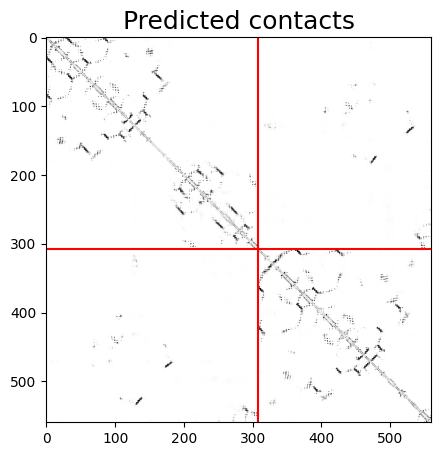

In [ ]:
#@title Visualize contacts
#@markdown The predicted contact map will be saved as a .npy object and PDF figure
dpi = 100 #@param {type: "integer"}
rasterize = True #@param {type:"boolean"}
title = "Predicted contacts" #@param {type: "string"}
download_predictions = False #@param {type:"boolean"}

f, ax = plt.subplots(1, 1, figsize=(6,5))
ax.imshow(res['contacts'][0].float().cpu().numpy(), cmap="Greys", rasterized=True)
ax.set_title(title, size=18)
if len(chain_break_indices[0]) > 0:
  for i in chain_break_indices[0]:
    ax.axvline(i, color="red")
    ax.axhline(i, color="red")
f.savefig(f"{jobname}.predicted_contacts.pdf", dpi=dpi, bbox_inches='tight')
np.save(f"{jobname}.predicted_contacts.npy", res['contacts'][0].float().cpu().numpy())
if download_predictions:
  files.download(f"{jobname}.predicted_contacts.pdf")
  files.download(f"{jobname}.predicted_contacts.npy")

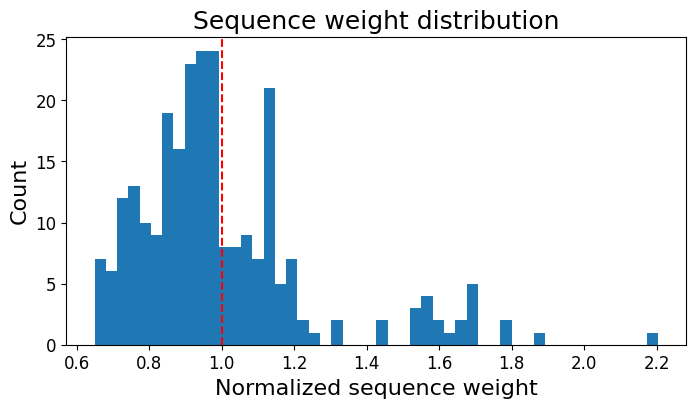

In [ ]:
#@title Visualize sequence weights
mean_seq_weights_a = np.mean(np.stack([res['seq_weights_list_d'][f"layer_{layer_idx}"][0].cpu().numpy() for layer_idx in range(16)]), axis=0)
mean_seq_weights_a *= msa_onehot_t.shape[1]
f, ax = plt.subplots(1, 1, figsize=(8,4))
_ = ax.hist(mean_seq_weights_a, bins=50)
ax.axvline(x=1, linestyle='--', color='red')
ax.set_title("Sequence weight distribution", size=18)
ax.set_xlabel("Normalized sequence weight", size=16)
ax.set_ylabel("Count", size=16)
ax.tick_params(axis='both', which='major', labelsize=12)